In [1]:
import cv2 as cv
from dataclasses import dataclass
from pathlib import Path
import requests
from tqdm.notebook import tqdm

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        headers = {'User-Agent': 'ComputerVisionExperiments/0.0 (https://github.com/seafoodfry/ml-workspace/tree/main/gpu-sandbox/vision)'}
        response = requests.get(self.url, headers=headers)
        response.raise_for_status()

        img_data = response.content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path, cv.IMREAD_UNCHANGED)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)

    def gray(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)


class ImageCache:
    def __init__(self, base_path: str = './img/009-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'zenitsu': ImageInfo( # https://www.pinterest.com/pin/zenitsu-the-scream-an-art-print-by-kimetsu-noyaiba--648588783851198232/
                image_path=self._base_path / 'zenitsu.jpg',
                url='https://i.pinimg.com/736x/30/f9/b5/30f9b569d050ea7f9d11ce8fb0a38a1b.jpg',
            ),
            'painting': ImageInfo( # https://cdn.shopify.com/s/files/1/0613/8039/5201/articles/RS_Hero_banner_traditional_chinese_art.png?v=1659619379
                image_path=self._base_path / 'painting.png.jpg',
                url='https://cdn.shopify.com/s/files/1/0613/8039/5201/articles/RS_Hero_banner_traditional_chinese_art.png?v=1659619379',
            ),
            'painting2': ImageInfo( # https://asianartnewspaper.com/traditional-chinese-painting-solitude/
                image_path=self._base_path / 'paintin-2.jpg',
                url='https://asianartnewspaper.com/wp-content/uploads/2021/08/1-whiling-away-summer-chinese-painting.jpg',
            ),
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def cwd(self):
        return self._base_path


CACHE = ImageCache()

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def naive_subsample(img, factor=2):
    """
    Naive subsampling by simply taking every nth pixel
    This will demonstrate aliasing problems
    """
    return img[::factor, ::factor]

def proper_subsample(img, factor=2):
    """
    Proper subsampling with Gaussian filtering to prevent aliasing
    1. Apply Gaussian blur with sigma proportional to downsampling factor
    2. Then subsample
    """
    # Calculate appropriate sigma based on downsampling factor.
    # Rule of thumb: sigma = factor/2
    sigma = factor/2
    
    # Kernel size should be odd and roughly 6*sigma.
    # 3 sigma deviations on each side capture 99.7% of the "energy".
    kernel_size = int(6*sigma)
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    # Apply Gaussian blur.
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)
    
    # Then subsample.
    return blurred[::factor, ::factor]

def demonstrate_subsampling(img, factor=2):
    if img.ndim > 2:
        raise ValueError(f'image should be in grayscale')
        
    # Get both subsampled versions.
    naive = naive_subsample(img, factor)
    proper = proper_subsample(img, factor)
    
    # Resize both back to original size for comparison.
    h, w = img.shape
    naive_upscaled = cv2.resize(naive, (w, h), interpolation=cv2.INTER_NEAREST)
    proper_upscaled = cv2.resize(proper, (w, h), interpolation=cv2.INTER_NEAREST)
    
    # Display results.
    plt.figure(figsize=(15, 7))
    
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {img.shape}')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(naive_upscaled, cmap='gray')
    plt.title('Naive Subsampling\n(with aliasing)')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(proper_upscaled, cmap='gray')
    plt.title('Proper Subsampling\n(anti-aliased)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Also show the actual subsampled sizes.
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.imshow(naive, cmap='gray')
    plt.title(f'Naive ({naive.shape})')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(proper, cmap='gray')
    plt.title(f'Proper ({proper.shape})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return naive, proper

# Example pyramid building function (for hierarchical LK).
def build_pyramid(img, levels=3):
    """
    Build an image pyramid for hierarchical LK
    Returns a list of images, each half the size of the previous
    """
    pyramid = [img]
    for _ in range(levels-1):
        img = proper_subsample(img)
        pyramid.append(img)
    return pyramid

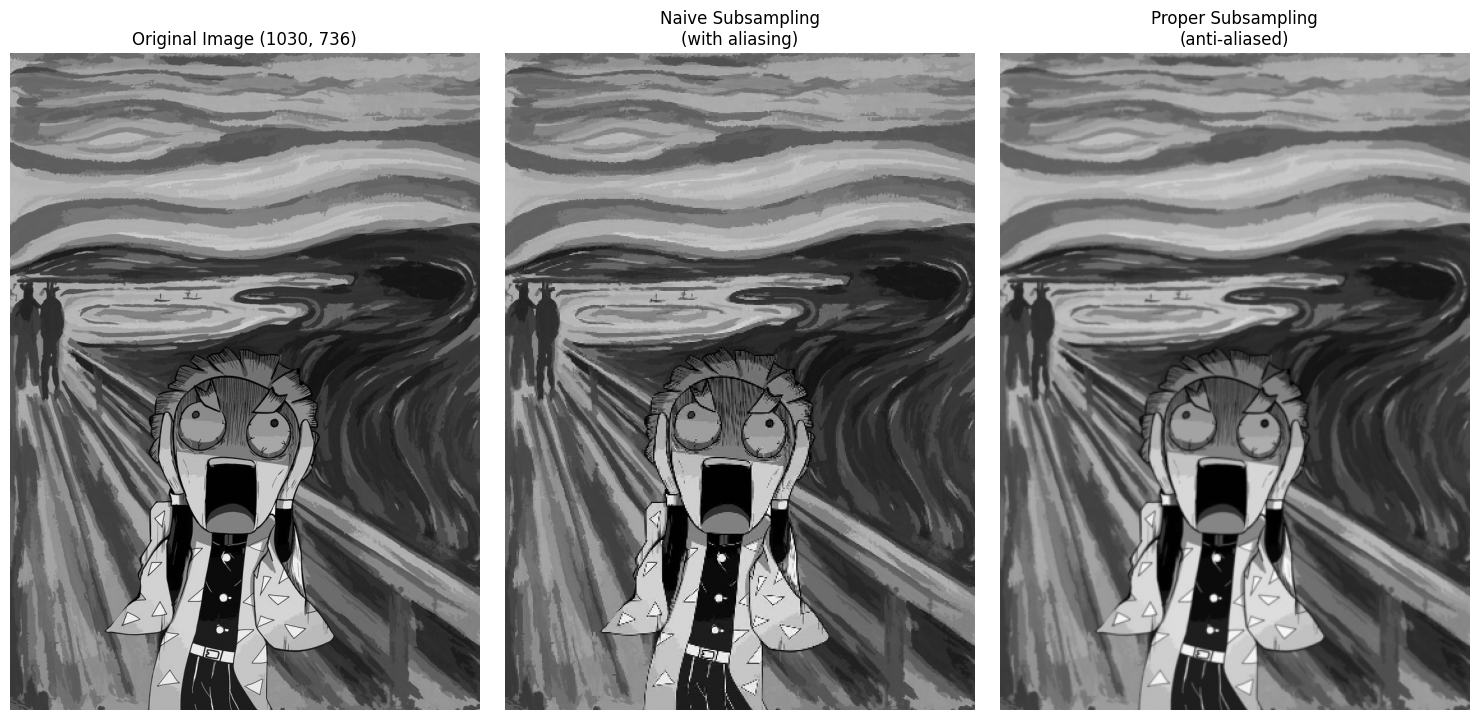

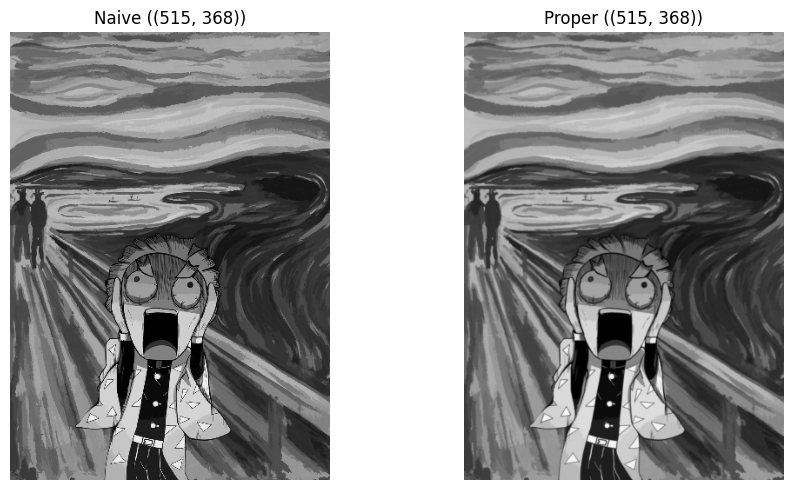

(array([[123,  99, 121, ..., 153, 154, 154],
        [101, 116, 127, ..., 156, 156, 155],
        [115, 128, 119, ..., 154, 152, 152],
        ...,
        [ 85,  89,  90, ..., 109,  77,  70],
        [ 90,  89,  91, ...,  71,  74,  70],
        [ 98,  88,  92, ...,  68,  86,  98]], shape=(515, 368), dtype=uint8),
 array([[108, 109, 122, ..., 154, 155, 155],
        [109, 115, 124, ..., 155, 155, 155],
        [119, 124, 123, ..., 154, 153, 152],
        ...,
        [ 87,  88,  90, ..., 100,  76,  73],
        [ 90,  89,  90, ...,  74,  73,  73],
        [ 94,  90,  91, ...,  81,  96, 105]], shape=(515, 368), dtype=uint8))

In [9]:
demonstrate_subsampling(CACHE['zenitsu'].gray())

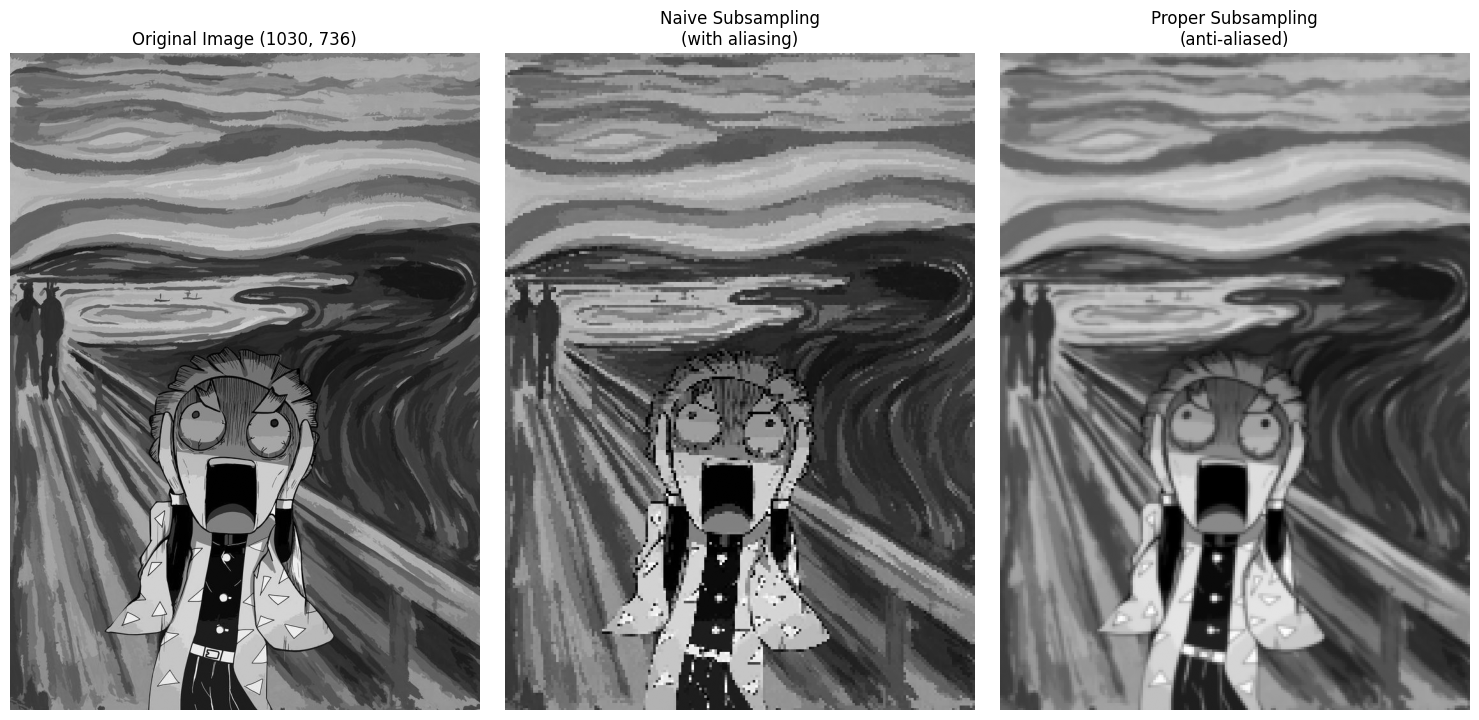

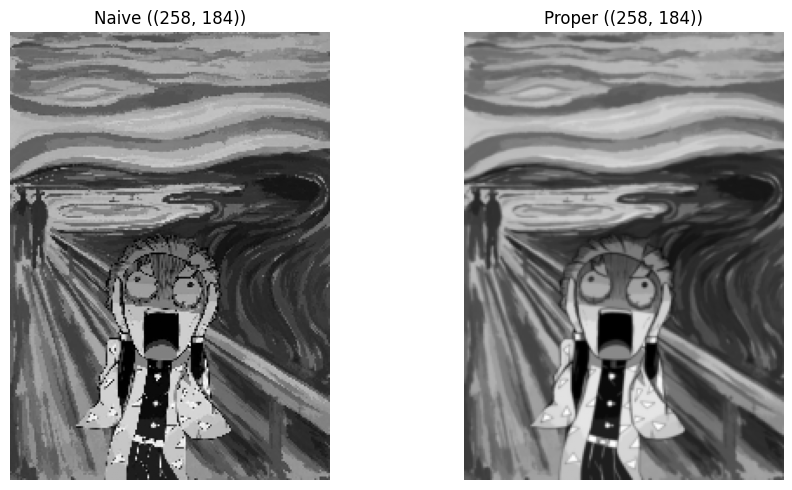

(array([[123, 121, 130, ..., 154, 151, 154],
        [115, 119, 127, ..., 158, 157, 152],
        [175, 135, 122, ..., 159, 159, 153],
        ...,
        [ 87,  84,  70, ..., 150, 161, 125],
        [ 85,  90,  86, ...,  73, 127,  77],
        [ 98,  92,  92, ...,  69,  63,  86]], shape=(258, 184), dtype=uint8),
 array([[112, 121, 128, ..., 155, 155, 155],
        [121, 124, 127, ..., 157, 155, 153],
        [142, 134, 133, ..., 158, 157, 154],
        ...,
        [ 85,  80,  77, ..., 139, 143, 119],
        [ 88,  88,  86, ...,  90, 105,  84],
        [ 91,  90,  88, ...,  71,  76,  89]], shape=(258, 184), dtype=uint8))

In [10]:
demonstrate_subsampling(CACHE['zenitsu'].gray(), factor=4)

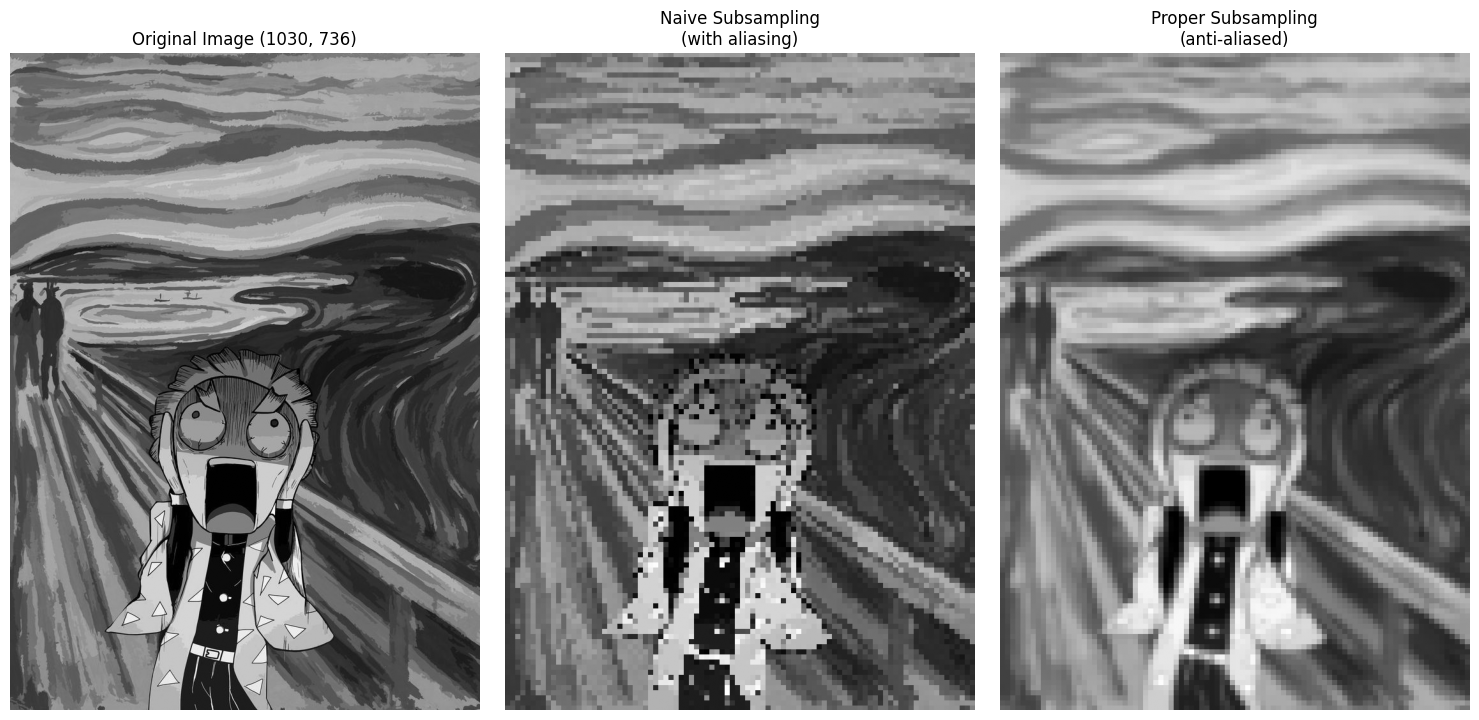

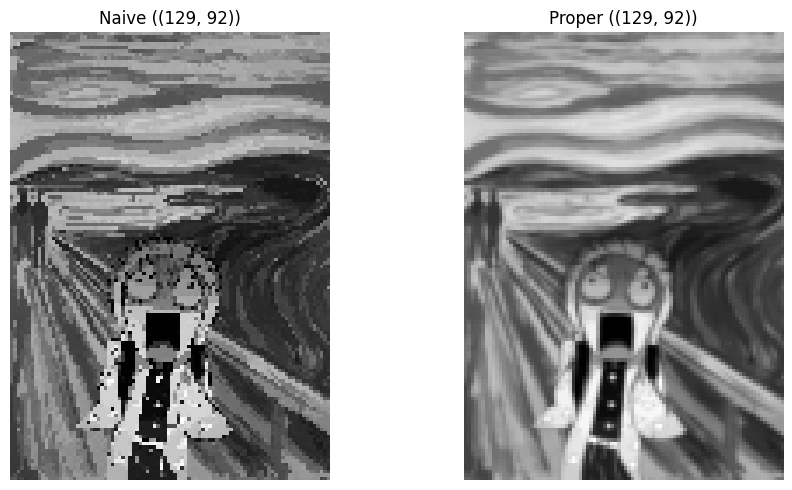

(array([[123, 130, 130, ..., 155, 154, 151],
        [175, 122, 128, ..., 157, 160, 159],
        [175, 166, 166, ..., 155, 157, 148],
        ...,
        [ 59,  57, 103, ..., 153,  92,  70],
        [ 60,  80,  63, ..., 145, 147, 147],
        [ 85,  86,  62, ...,  67,  76, 127]], shape=(129, 92), dtype=uint8),
 array([[121, 127, 128, ..., 143, 156, 155],
        [141, 139, 135, ..., 151, 157, 156],
        [166, 166, 160, ..., 155, 156, 155],
        ...,
        [ 65,  64,  80, ..., 108,  98,  76],
        [ 77,  73,  77, ..., 134, 137, 123],
        [ 87,  84,  77, ..., 116, 100, 101]], shape=(129, 92), dtype=uint8))

In [11]:
demonstrate_subsampling(CACHE['zenitsu'].gray(), factor=8)

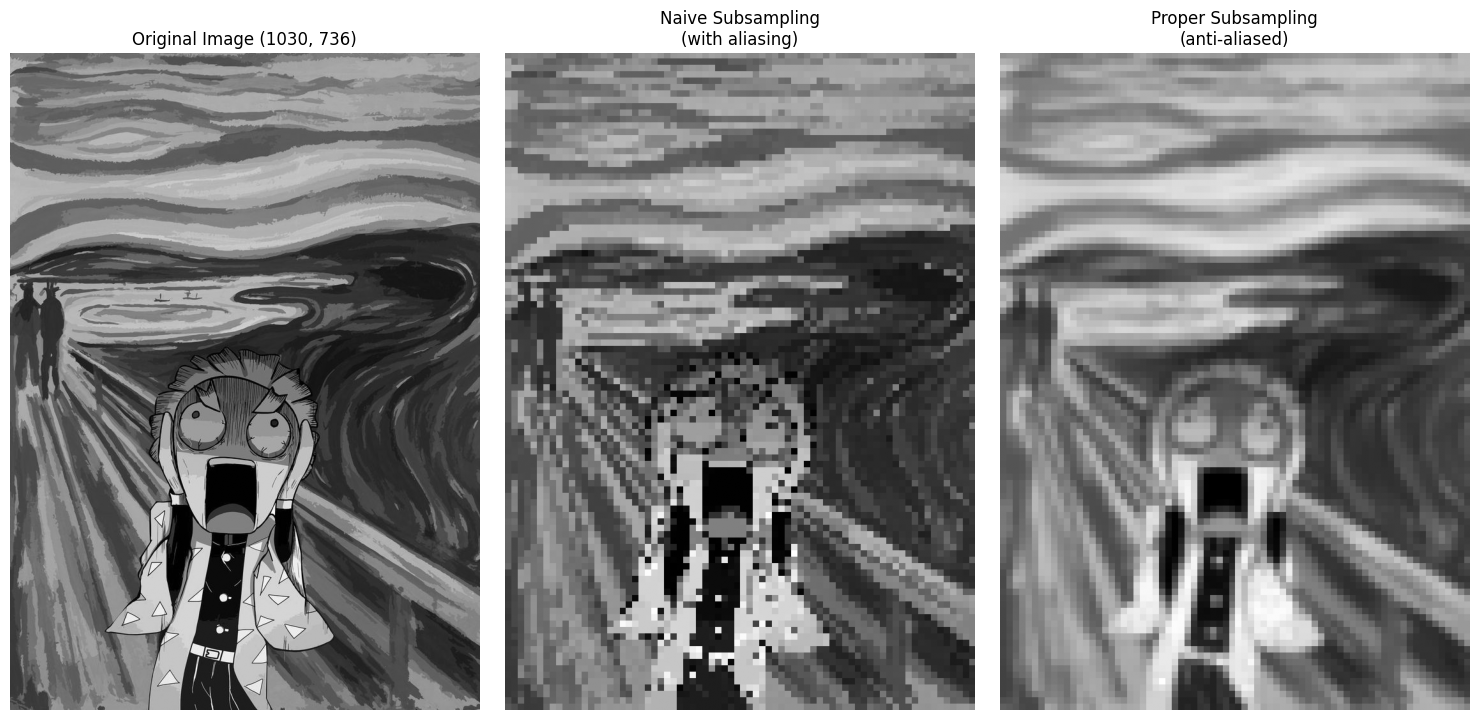

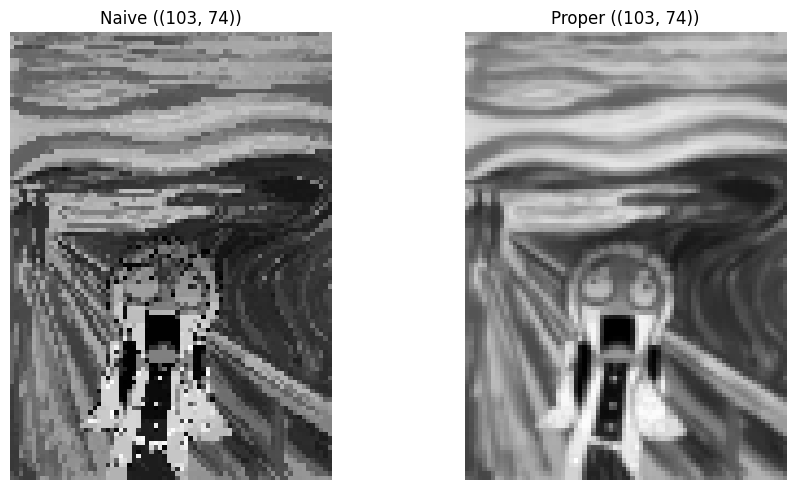

(array([[123, 127, 131, ..., 162, 154, 153],
        [168, 114, 134, ..., 158, 159, 158],
        [166, 172, 170, ..., 151, 149, 157],
        ...,
        [ 56,  61,  81, ...,  95,  60,  45],
        [ 78,  56, 104, ...,  98,  97,  71],
        [ 87,  78,  63, ..., 150, 151, 144]], shape=(103, 74), dtype=uint8),
 array([[125, 128, 128, ..., 138, 155, 155],
        [148, 146, 138, ..., 150, 157, 156],
        [167, 160, 143, ..., 153, 155, 156],
        ...,
        [ 57,  61,  72, ...,  83,  65,  55],
        [ 68,  70,  75, ..., 114, 109,  83],
        [ 81,  78,  73, ..., 132, 123, 112]], shape=(103, 74), dtype=uint8))

In [15]:
demonstrate_subsampling(CACHE['zenitsu'].gray(), factor=10)

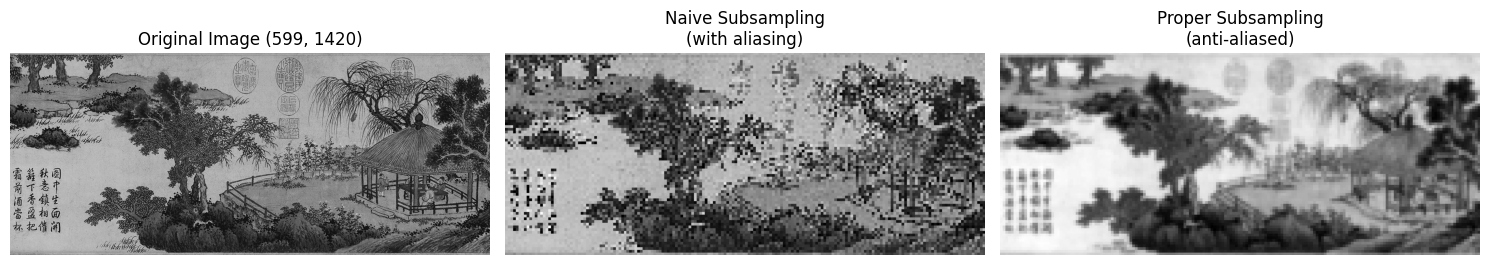

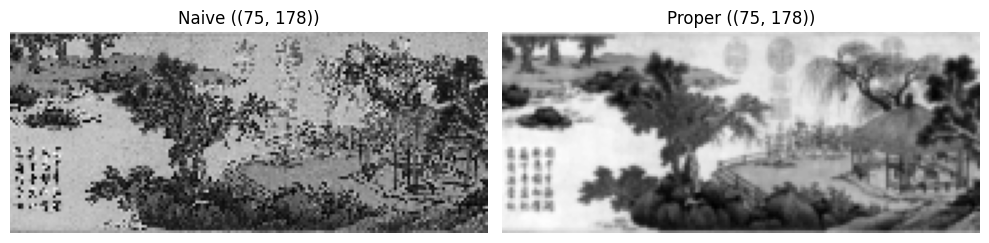

(array([[158, 161, 164, ..., 155, 153, 160],
        [ 39,  26, 123, ..., 152, 161, 163],
        [ 38,  59, 130, ..., 160, 170, 159],
        ...,
        [181, 184, 183, ..., 123,  58,  64],
        [170, 161, 169, ..., 119,  76,  69],
        [144, 146, 145, ...,  64,  81,  73]], shape=(75, 178), dtype=uint8),
 array([[156, 156, 160, ..., 162, 162, 162],
        [118, 121, 125, ..., 160, 162, 162],
        [ 80, 100, 117, ..., 163, 168, 169],
        ...,
        [181, 179, 178, ...,  97,  83,  75],
        [170, 170, 170, ..., 104,  87,  78],
        [153, 153, 156, ..., 118, 110, 113]], shape=(75, 178), dtype=uint8))

In [11]:
demonstrate_subsampling(CACHE['painting'].gray(), factor=8)

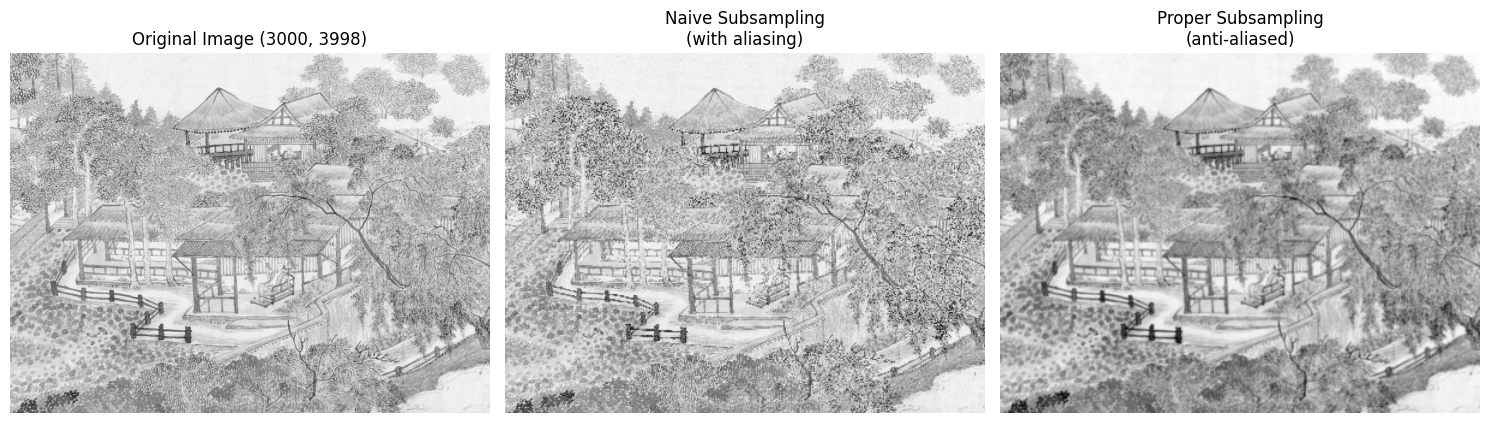

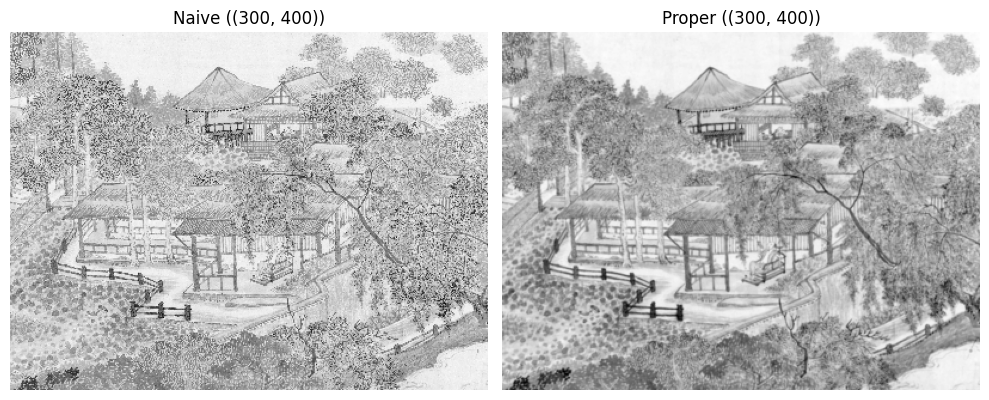

(array([[219, 136, 142, ..., 246, 246, 238],
        [218, 162, 216, ..., 247, 246, 246],
        [173, 230, 192, ..., 246, 246, 246],
        ...,
        [197, 190, 182, ..., 231, 232, 231],
        [183, 174, 177, ..., 234, 235, 233],
        [174, 169, 176, ..., 232, 233, 229]], shape=(300, 400), dtype=uint8),
 array([[150, 146, 153, ..., 247, 246, 246],
        [162, 176, 178, ..., 246, 246, 245],
        [156, 200, 185, ..., 246, 246, 246],
        ...,
        [191, 188, 184, ..., 232, 232, 232],
        [185, 181, 180, ..., 234, 235, 233],
        [177, 175, 169, ..., 233, 232, 230]], shape=(300, 400), dtype=uint8))

In [19]:
demonstrate_subsampling(CACHE['painting2'].gray(), factor=10)

In a digital image, our sampling rate is 1 pixel - that's our basic unit of measurement.

So if our original image could represent changes happening every 1 pixel, 
after subsampling by 2 we can only represent changes every 2 pixels.
Imagine we have a simple black and white pattern in our original image:

```
[B W B W B W B W]  # B=Black, W=White
```

After subsampling by 2, we might get:

```
[B B B B]  # We kept every other pixel
```

Now we've lost the ability to see that fast Black-White alternation. The fastest pattern we could now represent would be something like:

```
[B B W W B B W W]
```

This is what we mean by "changes every 2 pixels" - the smallest distance over which we can show a complete change in the image.

A cycle is one complete pattern repetition (like Black→White→Black in our case).

- If we need 2 pixels to complete one cycle (Black→White), that's 1/2 cycles per pixel.
- If we need 4 pixels to complete one cycle, that's 1/4 cycles per pixel.

Aliasing is when high frequency "folds back" and appears as a lower frequency.


Nyquist-Shannon sampling theorem: we need to remove frequencies above the Nyquist frequency (half the new sampling rate) before subsampling, or they'll alias.


The Nyquist-Shannon theorem in terms of images:

* Think of an image as a combination of patterns at different frequencies
* High frequency = rapid changes in intensity (like fine details, edges)
* Low frequency = gradual changes in intensity (like smooth gradients)
* When we subsample by 2, our new sampling rate is half the original
* Therefore, we can only accurately represent frequencies up to 1/4 of the original image frequency



The Nyquist frequency changes accordingly:

1. Original image: can capture frequencies up to 1/2 cycles per pixel
1. Subsampled image: can capture frequencies up to 1/4 cycles per original pixel
1. Or 1/2 cycles per new pixel in the subsampled coordinate system

The Nyquist frequency (1/2 cycles per pixel) means we need at least 2 pixels to represent one complete cycle of any pattern. If we try to represent patterns that cycle faster than this, we get aliasing - where the pattern appears to be something different than it actually is.


In [6]:
def lab_subsample(img, factor=2):
    """
    Subsample image in LAB color space with different treatment for L and AB channels
    
    Args:
        img: BGR image (OpenCV default format)
        factor: subsampling factor
    """
    # Convert BGR to LAB.
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Split channels
    L, a, b = cv2.split(lab)
    
    # Different sigma for luminance vs color channels.
    # Luminance (L) carries most detail, needs more aggressive filtering.
    sigma_L = factor/2
    # Color channels (a,b) can be filtered less aggressively.
    sigma_ab = factor/3
    
    # Kernel sizes.
    kernel_L = int(6 * sigma_L)
    kernel_ab = int(4 * sigma_ab)  # smaller kernel for color.
    if kernel_L % 2 == 0: kernel_L += 1
    if kernel_ab % 2 == 0: kernel_ab += 1
    
    # Filter and subsample each channel.
    L_small = cv2.GaussianBlur(L, (kernel_L, kernel_L), sigma_L)[::factor, ::factor]
    a_small = cv2.GaussianBlur(a, (kernel_ab, kernel_ab), sigma_ab)[::factor, ::factor]
    b_small = cv2.GaussianBlur(b, (kernel_ab, kernel_ab), sigma_ab)[::factor, ::factor]
    
    # Merge channels.
    lab_small = cv2.merge([L_small, a_small, b_small])
    
    # Convert back to BGR.
    return cv2.cvtColor(lab_small, cv2.COLOR_LAB2BGR)

def compare_color_subsampling(img, factor=2):
    """Compare regular RGB subsampling with LAB subsampling"""
    
    # Regular RGB subsampling.
    rgb_small = proper_subsample(img, factor)
    
    # LAB subsampling
    lab_small = lab_subsample(img, factor)
    
    # Resize both back to original size for comparison.
    h, w = img.shape[:2]
    rgb_upscaled = cv2.resize(rgb_small, (w, h), interpolation=cv2.INTER_LINEAR)
    lab_upscaled = cv2.resize(lab_small, (w, h), interpolation=cv2.INTER_LINEAR)
    
    # Convert to RGB for matplotlib.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_upscaled = cv2.cvtColor(rgb_upscaled, cv2.COLOR_BGR2RGB)
    lab_upscaled = cv2.cvtColor(lab_upscaled, cv2.COLOR_BGR2RGB)
    
    # Display.
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(img_rgb)
    plt.title(f'Original {img_rgb.shape}')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(rgb_upscaled)
    plt.title('RGB Subsampling')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(lab_upscaled)
    plt.title('LAB Subsampling')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also show actual small sizes.
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(rgb_small, cv2.COLOR_BGR2RGB))
    plt.title(f'RGB Small ({rgb_small.shape})')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(lab_small, cv2.COLOR_BGR2RGB))
    plt.title(f'LAB Small ({lab_small.shape})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

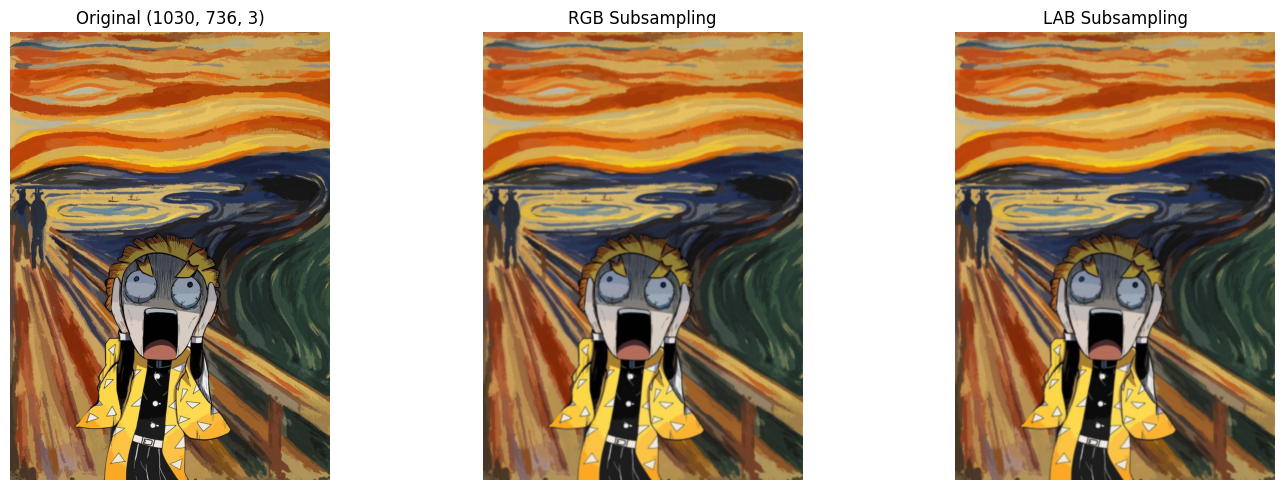

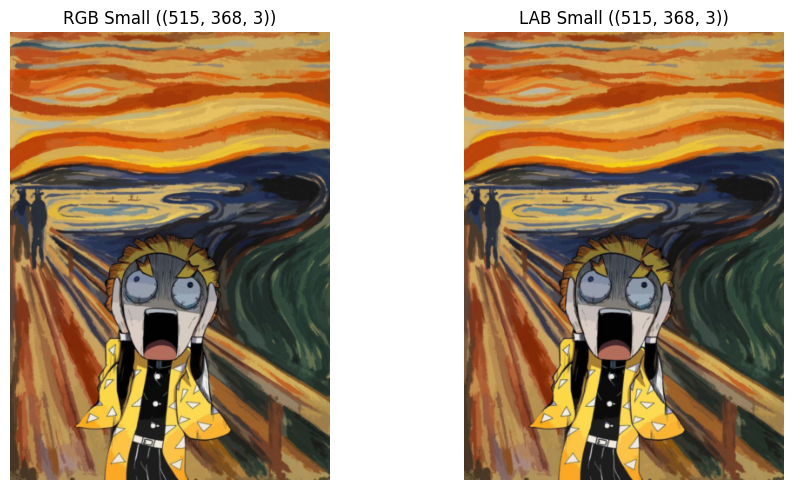

In [7]:
compare_color_subsampling(CACHE['zenitsu'].img)

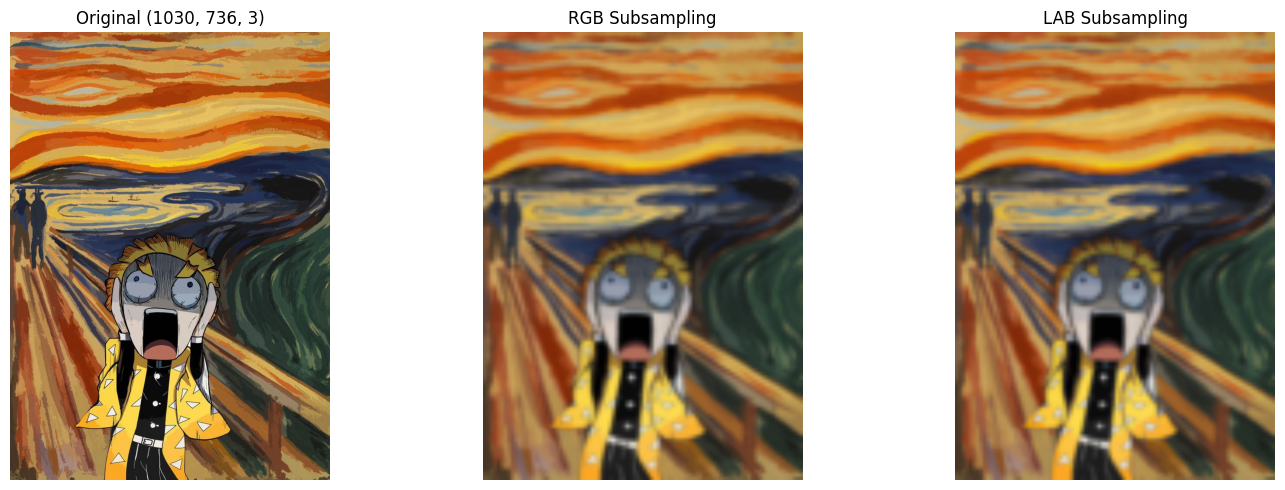

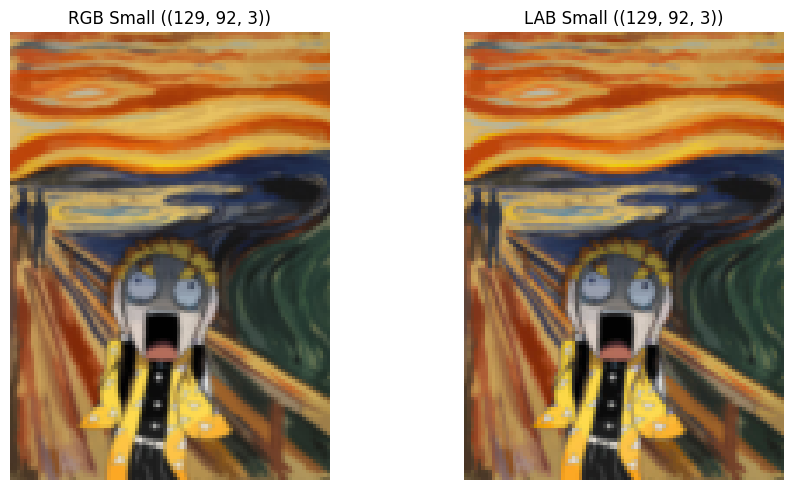

In [13]:
compare_color_subsampling(CACHE['zenitsu'].img, factor=8)

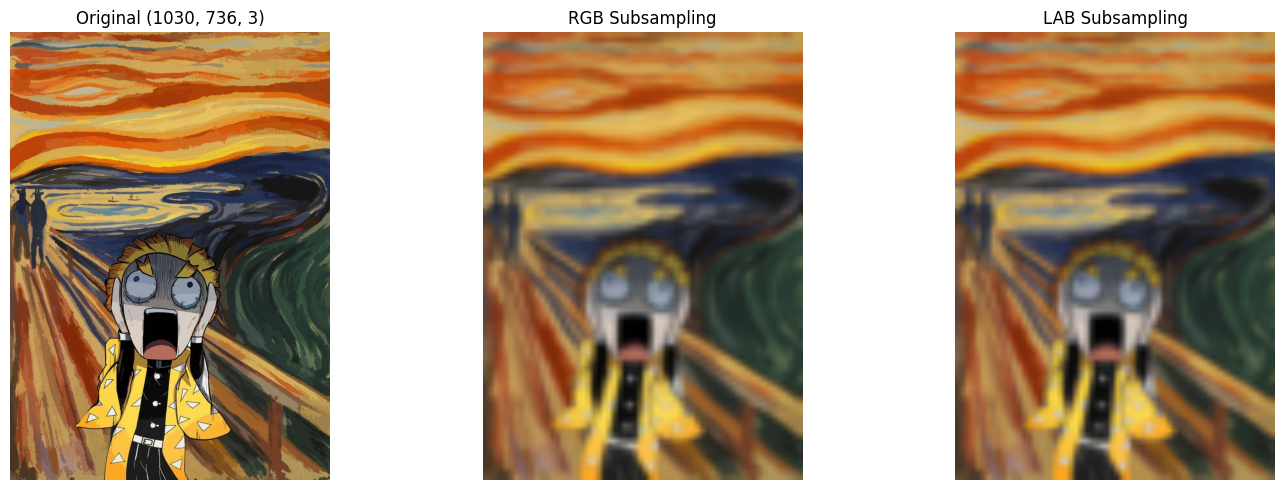

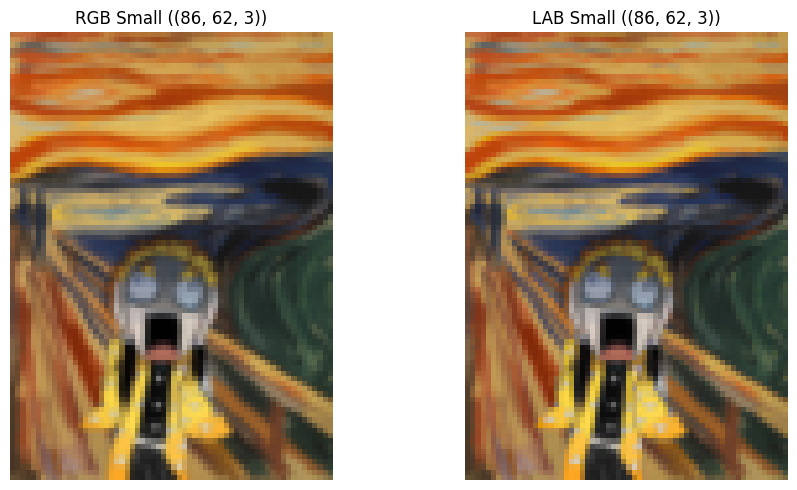

In [14]:
compare_color_subsampling(CACHE['zenitsu'].img, factor=12)